# Ablation Tests Results
Display evaluation metrics and create figures for the ablation test results

## Initialisation

In [1]:
import glob
import json
import numpy as np
import os
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

import initialise
import common
from display_utils import display_frames

In [2]:
SCENARIOS = ['within-site', 'out-of-site']
EXPERIMENTS = ['omit_one', 'ablation']
model_dirs = ['_'.join([s, t]) for t in EXPERIMENTS for s in SCENARIOS]
precision = 3       # floating point precision for results

### Function to Load Predictions and Statistics, and Generate Confidence Intervals

In [3]:
def get_results(experiment_name):
    pre_ = precision + 1
    stats_fname = f"ensemble{common.ENSEMBLE_SIZE:02}_stats.csv"
    scenario = experiment_name.split('_')[0]
    scenario_dir = '_'.join([scenario, 'models'])
    ens_stats = [pd.read_csv(os.path.join(common.MODELS_DIR, scenario_dir, stats_fname), index_col=(0,1))]

    model_dir = os.path.join(common.MODELS_DIR, experiment_name)
    with open(os.path.join(model_dir, 'experiment.json'), 'r') as f:
        experiment = json.load(f)
    tests = ['Proposed model'] + experiment['testNames']
    stats_fname = f"ensemble{common.ENSEMBLE_SIZE:02}_stats.csv"
    for num, test in enumerate(tests[1:]):
        test_name = f'test{num}'
        ens_stats.append(pd.read_csv(os.path.join(model_dir, test_name, stats_fname), index_col=(0,1)))
    ens_means = [stats_.mean(axis=1).unstack() for stats_ in ens_stats]

    ci_dict = {}
    for n, t in enumerate(ens_stats):
        a = t.loc[common.ANALYSIS_MODEL].T
        ci = stats.t.interval(common.CI, len(a)-1, loc=np.mean(a), scale=stats.sem(a))
        ci = ((ci[1] - ci[0]) / 2).round(pre_)
        ci_dict[tests[n]] = pd.DataFrame([ens_means[n].loc[common.ANALYSIS_MODEL].array, ci], index=['mean', 'ci'], columns=a.columns)
    df_list = []
    for num, test in enumerate(tests):
        df_dict={}
        df_dict.update(ci_dict[test].RMSE.round(pre_).add_prefix('RMSE_').to_dict())
        df_dict.update(ci_dict[test].Bias.round(pre_).add_prefix('Bias_').to_dict())
        df_dict.update(ci_dict[test].R2.round(pre_).add_prefix('R2_').to_dict())
        df_list.append(df_dict)
    return pd.DataFrame(df_list, index=tests)

### Function to format figure data

In [4]:
def format_figure_data(ens_stats, test_names, drop_tests=[None, None]):
    stats1_df = [None, None]
    temp_df = pd.concat(ens_stats[0], keys=pd.MultiIndex.from_arrays([test_names[0], ['Within-site'] * len(test_names[0])]), names=['Test name', 'Scenario'])
    if drop_tests[0] is not None:
        temp_df = temp_df.drop(drop_tests[0], level=0)
    temp_df = temp_df[['RMSE', 'Bias', 'R2']].stack().reset_index()
    stats1_df[0] = temp_df.rename(columns={'level_3': 'Statistic', 0: 'Value'})
    temp_df = pd.concat(ens_stats[1], keys=pd.MultiIndex.from_arrays([test_names[1], ['Out-of-site'] * len(test_names[1])]), names=['Test name', 'Scenario'])
    if drop_tests[1] is not None:
        temp_df = temp_df.drop(drop_tests[1], level=0)
    temp_df = temp_df[['RMSE', 'Bias', 'R2']].stack().reset_index()
    stats1_df[1] = temp_df.rename(columns={'level_3': 'Statistic', 0: 'Value'})
    return pd.concat(stats1_df)

### Function to format labels and add annotations to the sub-plots

In [5]:
def format_subplot(n, ax):
    xpos = -30 
    ax.annotate(fig_labels[n], xy=(0, 1), xytext=(xpos, 5), ha='center', va='bottom', xycoords='axes fraction', textcoords='offset points', fontsize=font_size)
    ax.xaxis.set_tick_params(labelsize=font_size, rotation=90)
    ax.yaxis.set_tick_params(labelsize=font_size)
    ax.set_xlabel(None)
    ax.set_ylabel(y_labels[n])
    if n == 1:
        ax.set_title('Within-site Scenario\n', size=title_size)
    elif n == 4:
        ax.set_title('Out-of-site Scenario\n', size=title_size)
    else:
        ax.set_title(None)
    for line_ in ax.get_lines():
        line_.set_color('black')
        line_.set_lw(1.25)
    annots = {}
    for path in ax.collections:
        points = path.get_offsets()
        point = points[~points.mask]
        if len(point) >= 2:
            annots[point[0]] = {'mean': round(point[1], 4)}
    for line_ in ax.get_lines():
        x_pos = line_.get_data()[0][0]
        ci = line_.get_data()[1]
        if ci[0] == ci[0]:
            annots[x_pos]['ci'] = np.round(ci, 4)
    return ax, annots

## Display Results
Display the RMSE, Bias, and R2 mean and CI for each test

In [6]:
results = [get_results(m) for m in model_dirs]
for e, ex in enumerate(EXPERIMENTS):
    print(f'\nExperiment: {ex}')
    print('====================\n')
    s = len(SCENARIOS)
    display_frames(results[e*s:e*s+s], SCENARIOS, precision=precision)


Experiment: omit_one



,RMSE_mean,RMSE_ci,Bias_mean,Bias_ci,R2_mean,R2_ci
Proposed model,20.868,0.009,0.221,0.037,0.698,0.001
Without weather,20.984,0.007,-0.227,0.031,0.690,0.000
Without climate zone,21.340,0.008,-0.060,0.032,0.680,0.000
With day-of-year,20.920,0.011,0.672,0.039,0.693,0.001
Without topography,21.557,0.014,0.406,0.029,0.676,0.001
Without location,20.964,0.011,-0.281,0.034,0.691,8.0e-04
,RMSE_mean,RMSE_ci,Bias_mean,Bias_ci,R2_mean,R2_ci
Proposed model,25.365,0.007,0.590,0.044,0.535,0.001
Without weather,26.735,0.008,0.009,0.042,0.481,7.0e-04
Without climate zone,25.418,0.007,0.740,0.042,0.530,4.0e-04



Experiment: ablation



,RMSE_mean,RMSE_ci,Bias_mean,Bias_ci,R2_mean,R2_ci
Proposed model,20.868,0.009,0.221,0.037,0.698,0.001
Conv filters: 32,20.926,0.009,-0.000,0.032,0.692,0.001
Conv layers: 3,21.319,0.011,-0.166,0.034,0.680,4.0e-04
Dense layers: 2,21.224,0.013,-2.432,0.033,0.687,0.001
Dense units: 256,20.926,0.011,-0.601,0.037,0.692,0.001
Dropout: 0.5,22.327,0.007,-0.204,0.050,0.650,0.000
Batch size: 32,20.710,0.012,-0.410,0.035,0.700,0.000
,RMSE_mean,RMSE_ci,Bias_mean,Bias_ci,R2_mean,R2_ci
Proposed model,25.365,0.007,0.590,0.044,0.535,0.001
Conv filters: 32,25.189,0.009,-0.092,0.062,0.540,0.000


## Generate the Ablation Test Figures

### Load Summary Statistics

In [7]:
ens_stats = [[], [], [], []]
stats_fname = f"ensemble{common.ENSEMBLE_SIZE:02}_stats.csv"
for num, dir_ in enumerate(sorted(glob.glob(os.path.join(common.MODELS_DIR, '*site_models')), reverse=True)):
    ens_stats[num].append(pd.read_csv(os.path.join(dir_, stats_fname), index_col=(0,1)).loc[common.ANALYSIS_MODEL].T)
    ens_stats[num+2].append(pd.read_csv(os.path.join(dir_, stats_fname), index_col=(0,1)).loc[common.ANALYSIS_MODEL].T)

all_tests = []
for num, model_dir in enumerate(model_dirs):
    with open(os.path.join(common.MODELS_DIR, model_dir, 'experiment.json'), 'r') as f:
        experiment = json.load(f)
    tests = experiment['testNames']
    all_tests.append(['Proposed model'] + tests)
    for t_num, test in enumerate(tests):
        test_name = f'test{t_num}'
        ens_stats[num].append(pd.read_csv(os.path.join(common.MODELS_DIR, model_dir, test_name, stats_fname), index_col=(0,1)).loc[common.ANALYSIS_MODEL].T)

### Labels and settings for use in the figures

In [8]:
all_tests[0][1] = 'Without meteorology'
all_tests[1][1] = 'Without meteorology'
all_tests[2] = ['Proposed', 'Conv filters', 'Conv layers', 'FC layers', 'FC units', 'Dropout', 'Batch size']
all_tests[3] = ['Proposed', 'Conv filters', 'FC layers', 'FC units', 'x', 'Dropout', 'Batch size', 'Epochs']
o = all_tests[0]
order1 = [o[0], o[1], o[2], o[4], o[5], o[3]]
y_labels = ['RMSE (%)', 'Bias (%)', '$R^2$', 'RMSE (%)', 'Bias (%)', '$R^2$',]
fig_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', ]

font_size = 7
title_size = 10
sns.set_context("paper", rc={"font.size": font_size, "axes.titlesize": title_size, "axes.labelsize": font_size})   
sns.set_style("ticks")
palette = [sns.color_palette()[0], sns.color_palette()[1], sns.color_palette()[2], sns.color_palette()[4],
           sns.color_palette()[5], sns.color_palette()[6], sns.color_palette()[7], sns.color_palette()[8]]

### Inputs Ablation Tests

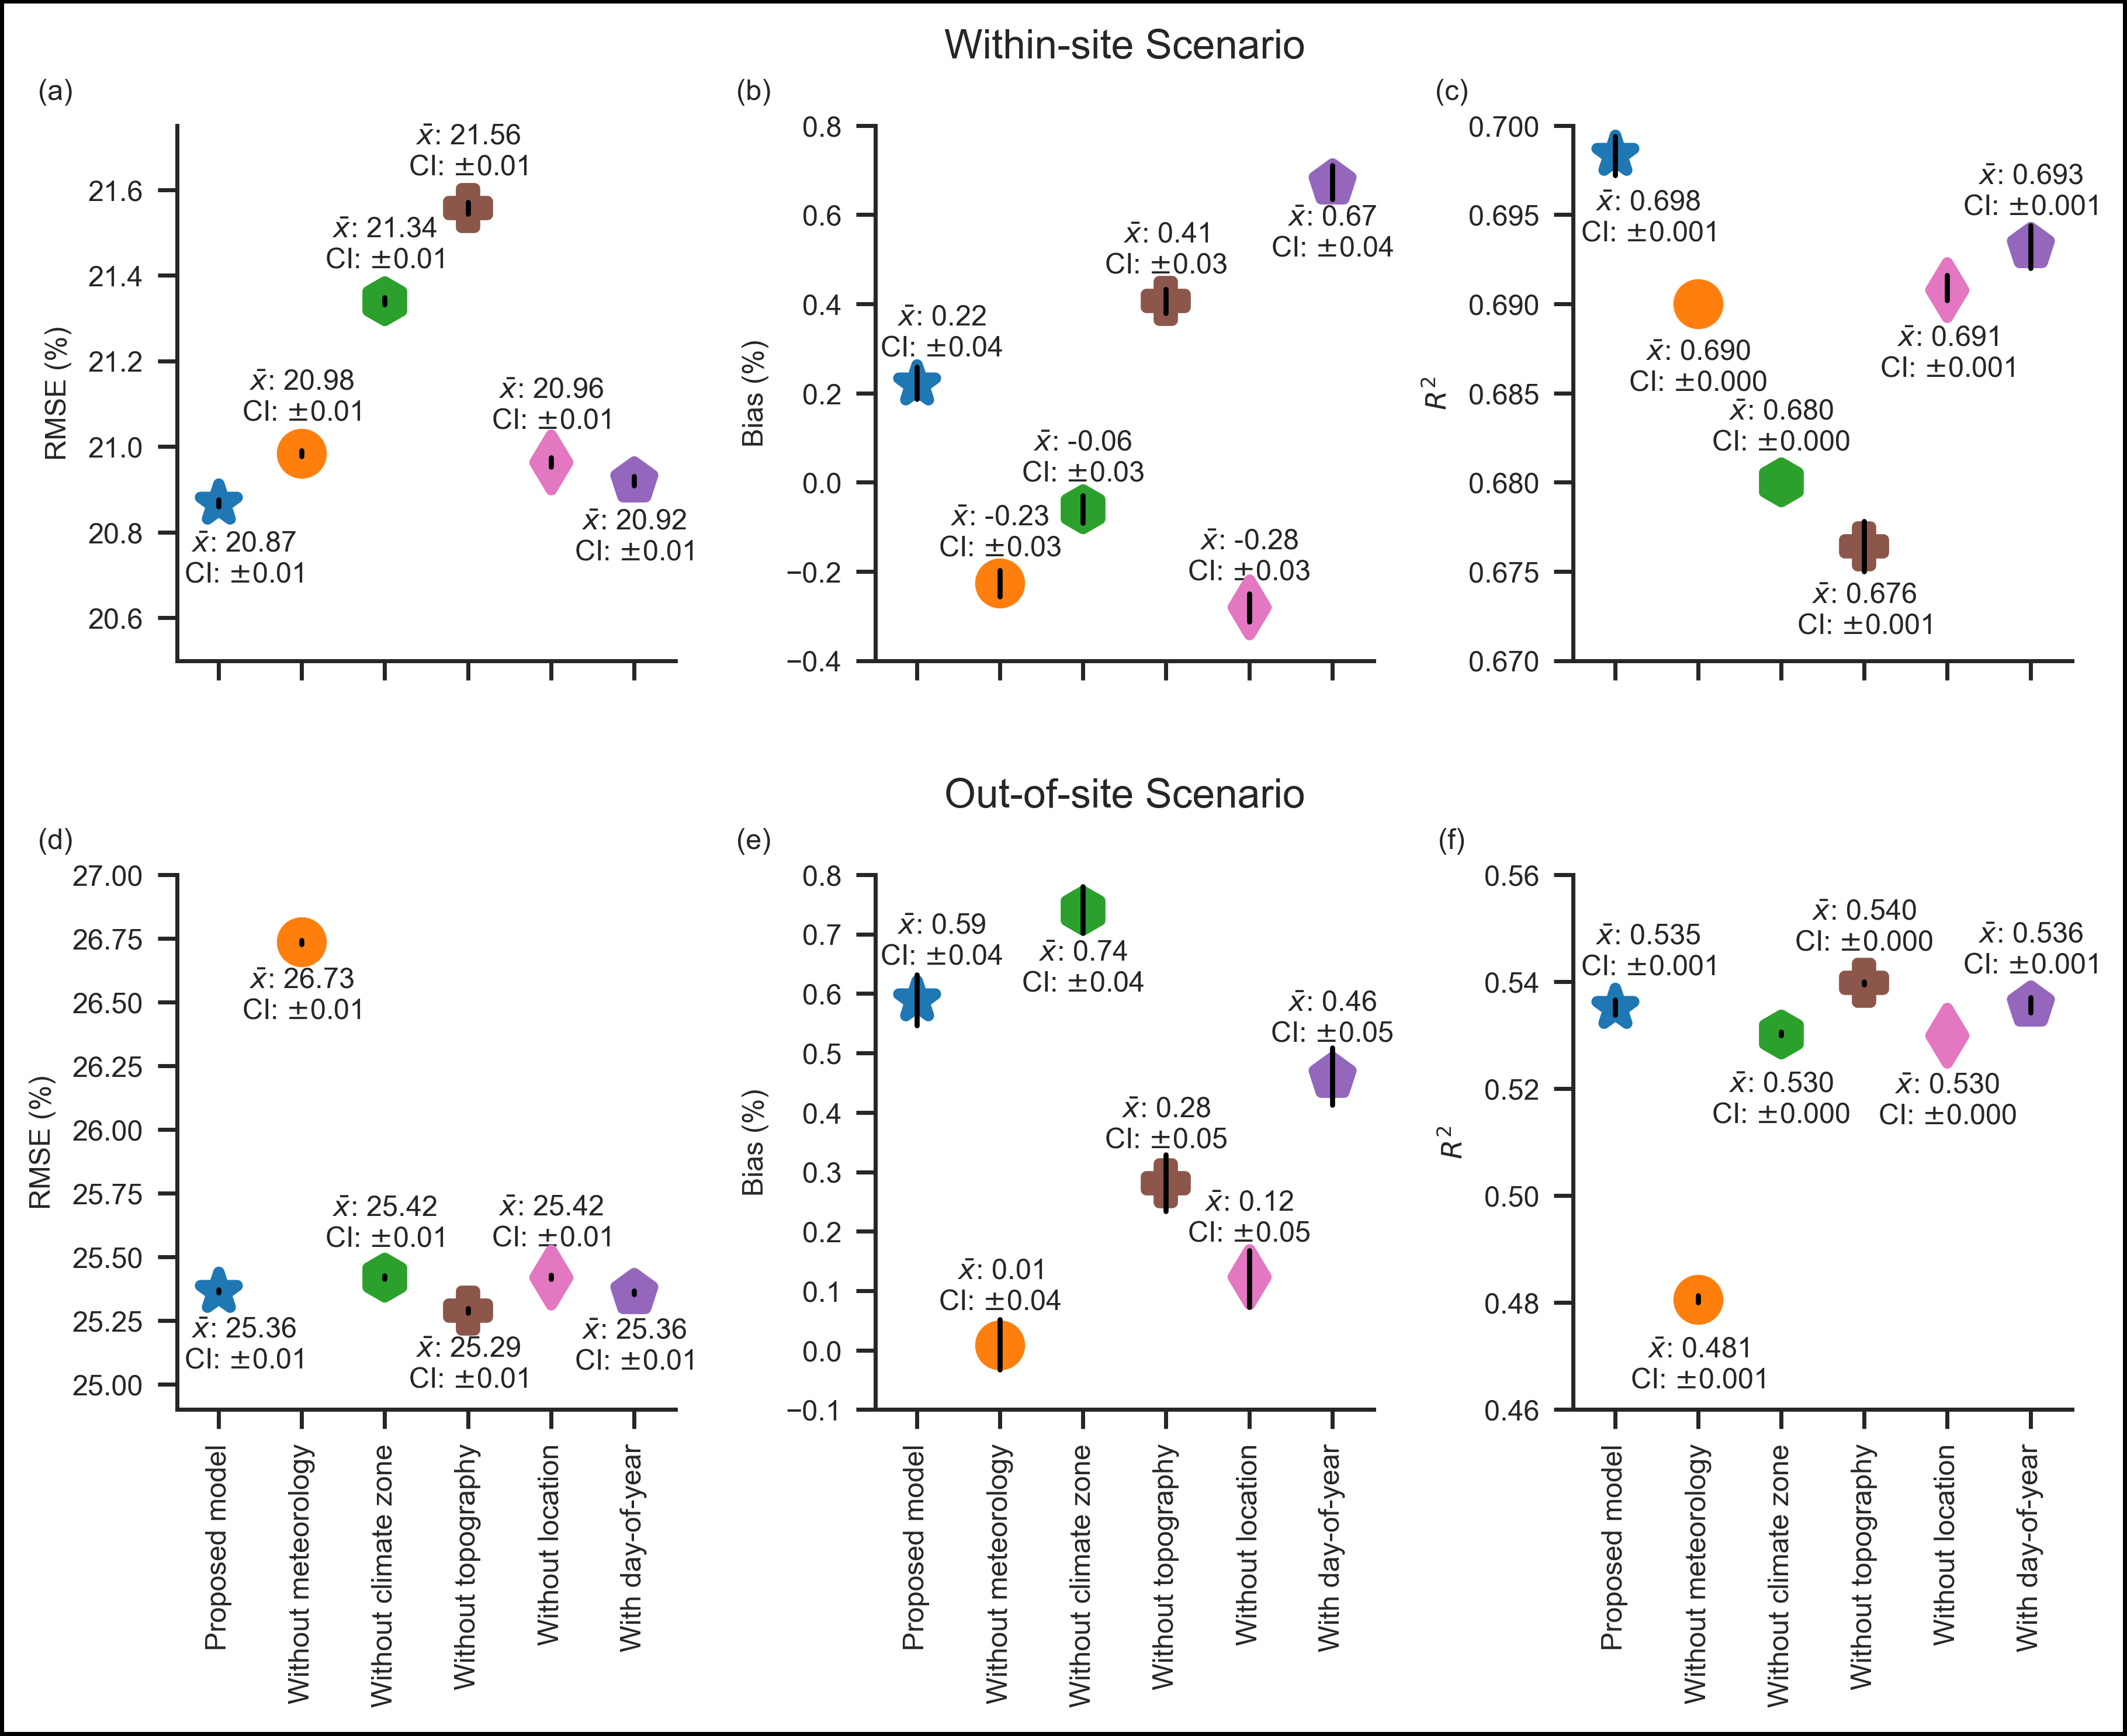

In [9]:
stats1_df = format_figure_data(ens_stats[0:2], all_tests[0:2])
g = sns.catplot(data=stats1_df, y='Value', x='Test name', col='Statistic', row='Scenario', hue='Test name', order=order1,
                kind="point", markers=['*', 'o', 'h', 'p', 'P', 'd'], palette=palette, join=False,  scale=1.75,
                sharey=False, sharex=True)
fig = g.fig
fig.set_size_inches(6.84, 4.75)
fig.set_dpi(500)
fig.set_edgecolor('black')
fig.set_linewidth(2)
for n, ax in enumerate(g.axes.ravel()):
    ax, annots = format_subplot(n, ax)
    for x, dict_ in annots.items():
        ha = 'center'
        if n == 0:
            ax.set_ylim([20.5, 21.75])
            y_off = -0.065 if x in [0, 5] else 0.065
            va = 'top' if x in [0, 5] else 'bottom'
        elif n == 1:
            ax.set_ylim([-0.4, 0.8])
            va = 'top' if x == 5 else 'bottom'
            y_off = -0.05 if x == 5 else 0.05
        elif n == 2:
            ax.set_ylim([0.67, 0.70])
            y_off = 0.0015 if x in [2, 5] else -0.002
            va = 'bottom' if x in [2, 5] else 'top'
        elif n == 3:
            ax.set_ylim([24.9, 27])
            y_off = 0.1 if x in [2, 4] else -0.1
            va = 'bottom' if x in [2, 4] else 'top'
        elif n == 4:
            ax.set_ylim([-0.1, 0.8])
            va = 'top' if x == 2 else 'bottom'
            y_off = -0.05 if x == 2 else 0.05
        else:  # n == 5:
            ax.set_ylim([0.46, 0.56])
            y_off = 0.005 if x in [0, 3, 5] else -0.007
            va = 'bottom' if x in [0, 3, 5] else 'top'
        y_pos = dict_['mean'] + y_off
        ci = (dict_['ci'][1] - dict_['ci'][0]) / 2
        if n in [2, 5]:
            x_pos = 0.4 if x == 0 else x
            text = r"$\bar x$" + f": {round(dict_['mean'],3):.3f}\nCI: $\pm${ci:.3f}"
        else:
            x_pos = 0.3 if x == 0 else x
            text = r"$\bar x$" + f": {round(dict_['mean'],2):.2f}\nCI: $\pm${ci:.2f}"
        ax.annotate(text, (x_pos, y_pos), va=va, ha=ha, size=font_size)
output_dir = common.FIGURES_DIR
plt.subplots_adjust(wspace=0.4, hspace=0.4)
fig.savefig(os.path.join(output_dir, 'Input ablation.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.2, dpi=500)

### Architecture Ablation Tests

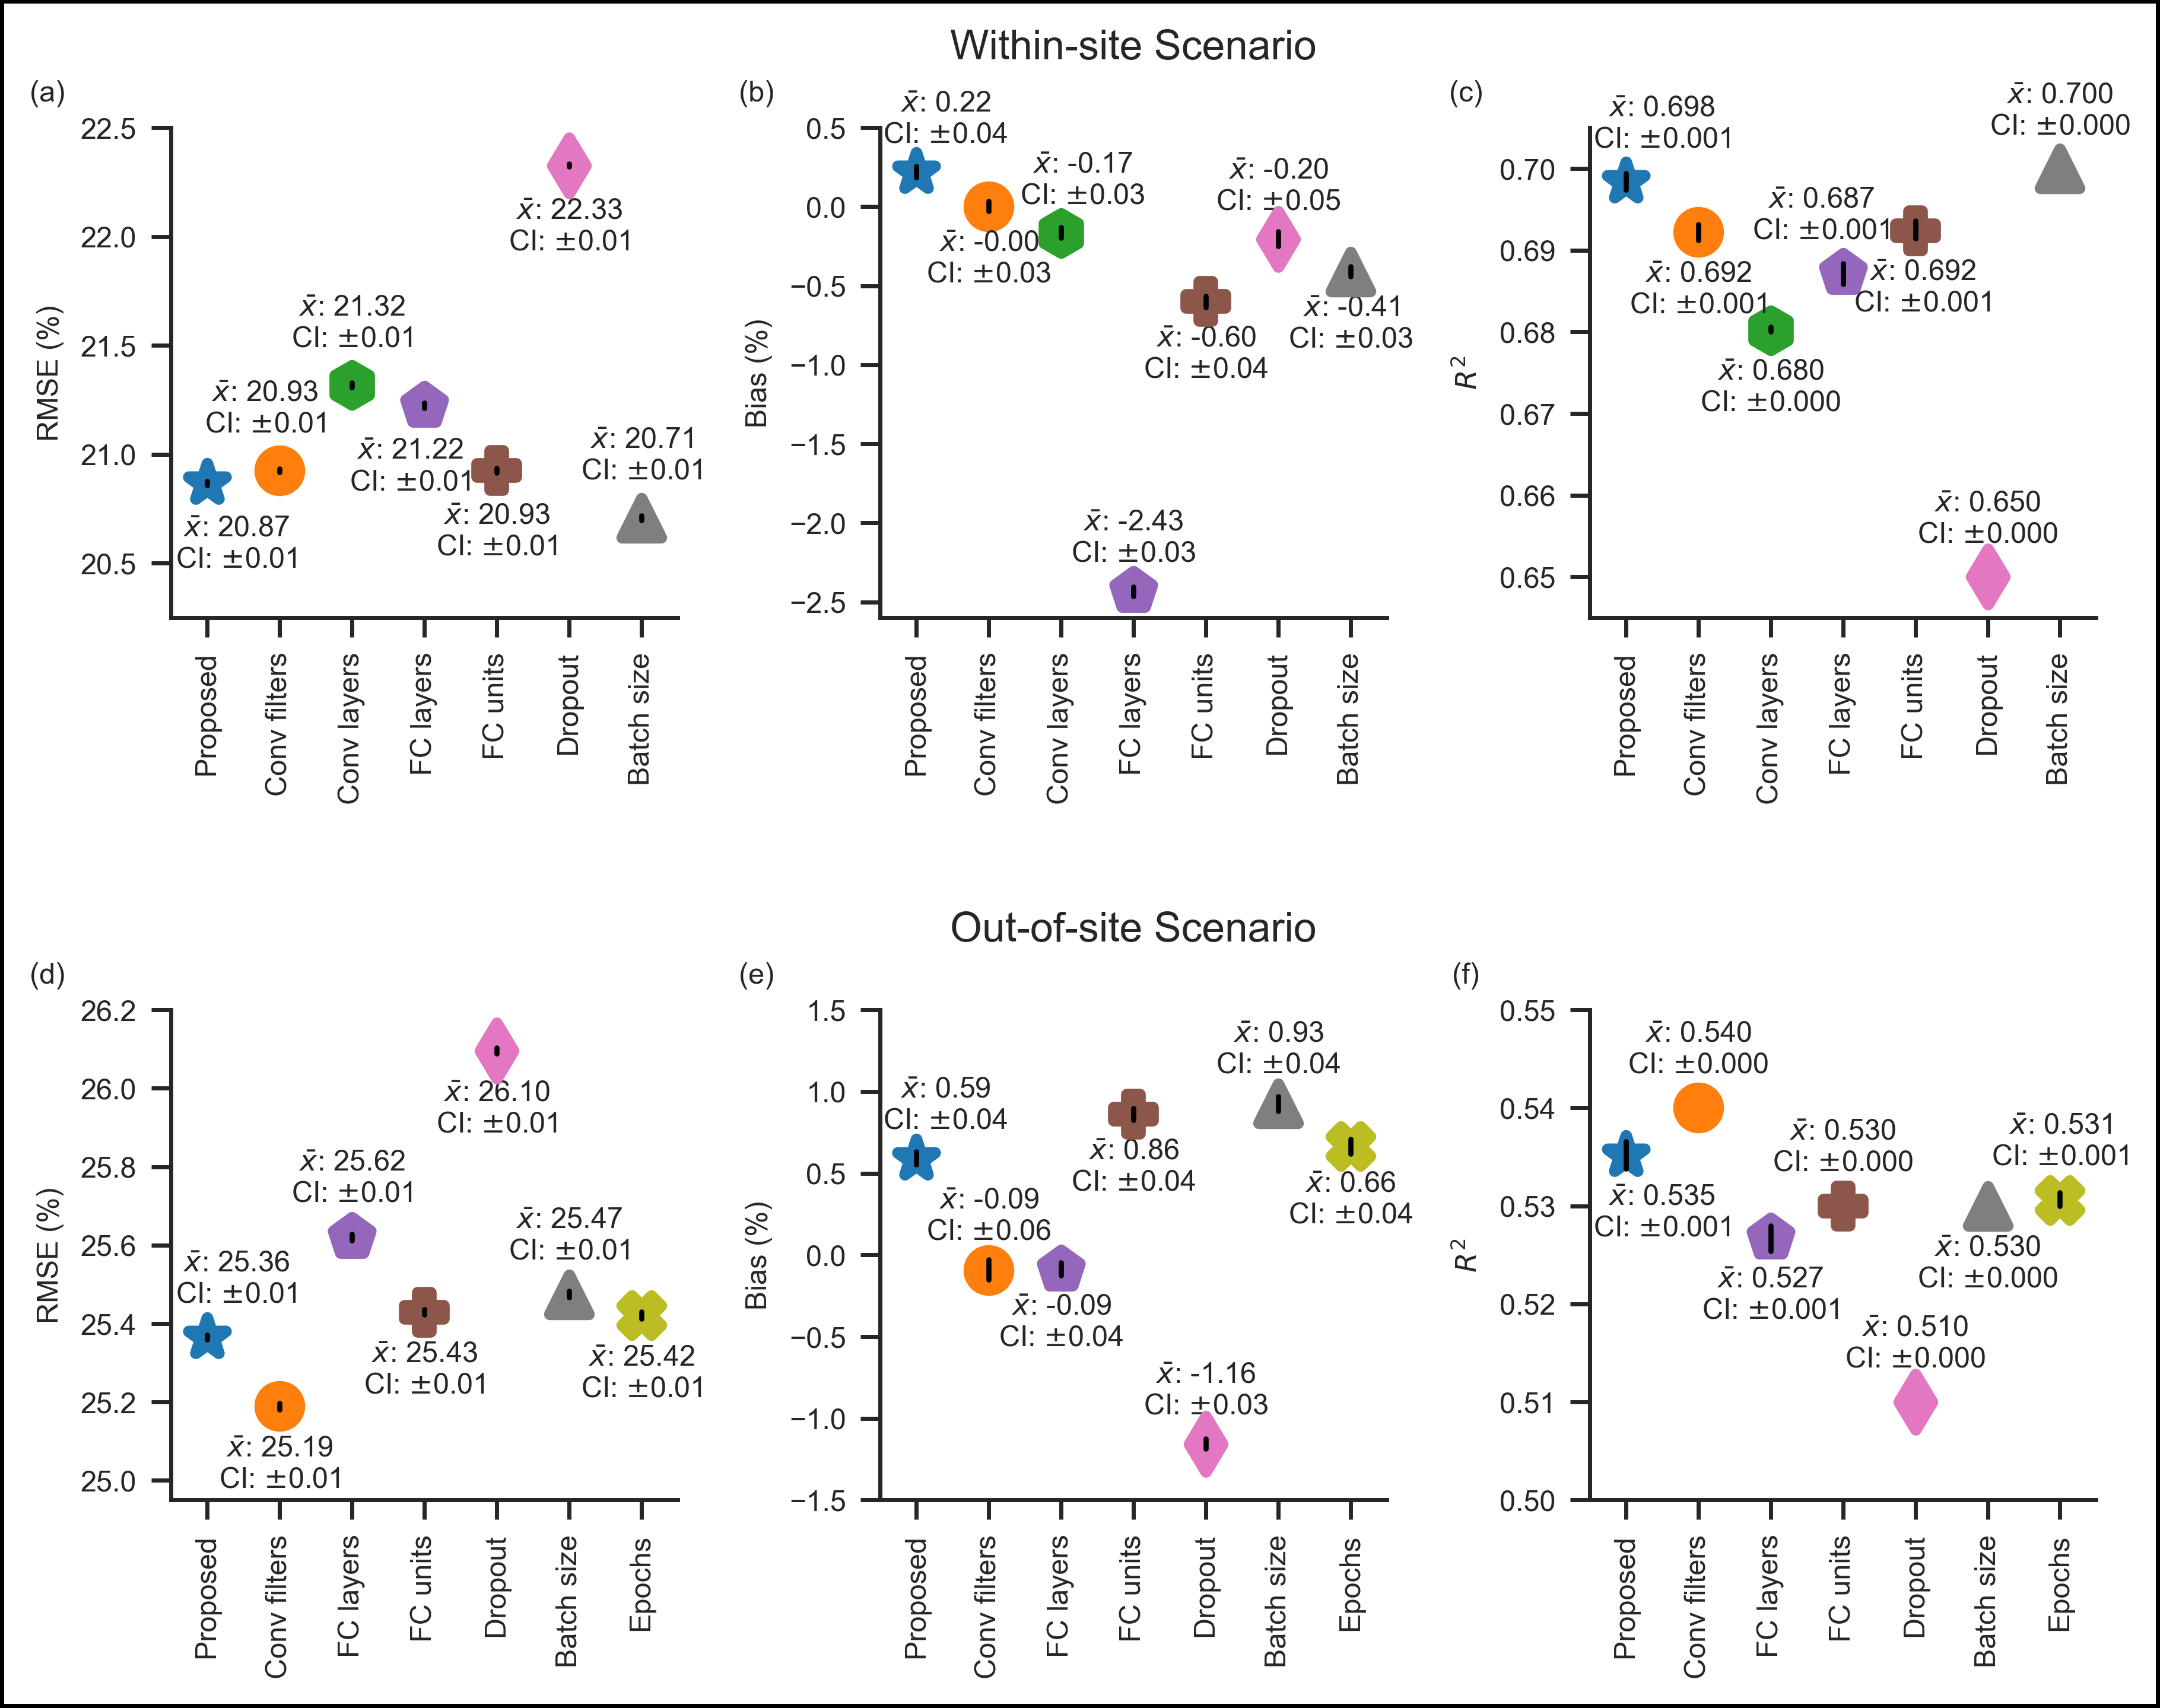

In [10]:
stats2_df = format_figure_data(ens_stats[2:4], all_tests[2:4], [None, all_tests[3][4]])
g = sns.catplot(data=stats2_df, y='Value', x='Test name', col='Statistic', row='Scenario', hue='Test name',
                kind="point", markers=['*', 'o', 'h', 'p', 'P', 'd', '^', 'X'], palette=palette, join=False,  scale=1.75,
                sharey=False, sharex=False)
fig = g.fig
fig.set_size_inches(6.8075, 5.0)
fig.set_dpi(500)
fig.set_edgecolor('black')
fig.set_linewidth(2)
for n, ax in enumerate(g.axes.ravel()):
    ax, annots = format_subplot(n, ax)
    for x, dict_ in annots.items():
        ha = 'center'
        x_pos = 0.4 if x == 0 else x
        if n == 0:
            ax.set_ylim([20.25, 22.5])
            y_off = 0.15 if x in [1, 2, 6] else -0.15
            va = 'bottom' if x in [1, 2, 6] else 'top'
            x_pos = x_pos - 0.2 if x == 1 else x_pos - 0.2 if x == 3 else x_pos
        elif n == 1:
            ax.set_ylim([-2.6, 0.5])
            y_off = 0.15 if x in [0, 2, 3, 5] else -0.15
            va = 'bottom' if x in [0, 2, 3, 5] else 'top'
            x_pos = x_pos + 0.3 if x == 2 else x_pos
        elif n == 2:
            ax.set_ylim([0.645, 0.705])
            y_off = -0.0035 if x in [1, 2, 4] else 0.0035
            va = 'top' if x in [1, 2, 4] else 'bottom'
            x_pos = x_pos + 0.1 if x in [0, 4] else x_pos - 0.3 if x == 3 else x_pos
        elif n == 3:
            ax.set_ylim([24.95, 26.2])
            va = 'bottom' if x in [0, 2, 5] else 'top'
            y_off = 0.075 if x in [0, 2, 5] else -0.075
        elif n == 4:
            ax.set_ylim([-1.5, 1.5])
            va = 'bottom' if x in [0, 1, 4, 5] else 'top'
            y_off = 0.15 if x in [0, 1, 4, 5] else -0.15
        else:  # n == 5:
            ax.set_ylim([0.50, 0.55])
            y_off = -0.003 if x in [0, 2, 5] else 0.003
            va = 'top' if x in [0, 2, 5] else 'bottom'
            x_pos = x_pos + 0.1 if x == 0 else x_pos
        y_pos = dict_['mean'] + y_off
        ci = (dict_['ci'][1] - dict_['ci'][0]) / 2
        if n in [2, 5]:
            text = r"$\bar x$" + f": {round(dict_['mean'],3):.3f}\nCI: $\pm${ci:.3f}"
        else:
            text = r"$\bar x$" + f": {round(dict_['mean'],2):.2f}\nCI: $\pm${ci:.2f}"
        ax.annotate(text, (x_pos, y_pos), va=va, ha=ha, size=font_size)
output_dir = common.FIGURES_DIR
plt.subplots_adjust(wspace=0.4, hspace=0.8)
fig.savefig(os.path.join(output_dir, 'Architecture ablation.jpeg'), format="jpeg", bbox_inches='tight', pad_inches=0.2, dpi=500)